# Vision transformer

## Preliminaries

### Libraries and imports

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

### Global variables

In [17]:
# MNIST images are 28x28
IMAGE_SIZE = 28

# Divide image into (28/7)x(28/7) patches
PATCH_SIZE = 7
NUM_SPLITS = IMAGE_SIZE // PATCH_SIZE
NUM_PATCHES = NUM_SPLITS ** 2

BATCH_SIZE = 100
EMBEDDING_DIM = 8
NUM_HEADS = 2
NUM_CLASSES = 10
NUM_TRANSFORMER_LAYERS = 4
HIDDEN_DIM = 16
EPOCHS = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## The `MNIST` dataset

See [here](https://en.wikipedia.org/wiki/MNIST_database) for details.

In [18]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist['data'], mnist['target'].astype(int)

In [19]:
# Normalize and reshape
X = X / 255.0
X = X.reshape(-1, 1, 28, 28)  # shape: (n_samples, channels, height, width)
# 1 car canal (greyscale), 3 si RGB

In [20]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=42)

In [21]:
# Convert to Pytorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [22]:
# Use dataloader to generate minibatches
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=1000, shuffle=False)

## Patch Embedding Layer

The first module to implement is a module that will transformed a tensor
of size `BATCH_SIZE` \* 1 \* `IMAGE_SIZE` \* `IMAGE_SIZE` into a tensor
of size `BATCH_SIZE` \* `NUM_PATCHES` \* `EMBEDDING_DIM`. This can be
done by using a `nn.Conv2d` module with both the stride and the kernel
the size of a patch.

In [23]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=1, patch_size=7, embedding_dim=64):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        # Use `nn.Conv2d` to split the image into patches
        self.projection = nn.Conv2d(in_channels, embedding_dim,kernel_size=patch_size, stride=7)

    def forward(self, x):
        # `x` is `BATCH_SIZE` * 1 * `IMAGE_SIZE` * `IMAGE_SIZE`

        # Project `x` into a tensor of size `BATCH_SIZE` * `EMBEDDING_DIM` *
        # `NUM_SPLITS` * `NUM_SPLITS`
        x = self.projection(x)

        # Flatten spatial dimensions to have a tensor of size `BATCH_SIZE` *
        # `EMBEDDING_DIM` * `NUM_PATCHES`
       # Cette ligne sert à transformer la grille 2D de patches en une séquence 1D (une liste), car le Transformer ne comprend que les listes (comme une phrase de mots).
        # L'action de .flatten(2)PyTorch garde les dimensions 0 et 1 intactes. Il écrase les dimensions 2 et 3 ($4 \times 4$) en une seule ($16$).
        x = x.flatten(2) # x de dim (-1, 8, 16] 8 dim vecteur qui définit, 16 car 4x4 largeur hauteur obtenu car 28/7 = 4
        #Interprétation : On a 100 images, décrites par 8 caractéristiques, réparties en une suite de 16 morceaux.

        # Put the `NUM_PATCHES` dimension at the second place to have a tensor
        # of size `BATCH_SIZE` * `NUM_PATCHES`` * `EMBEDDING_DIM`
        x = x.permute([0,2,1])

        return x

## Transformer encoder

In [24]:
class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim, num_heads, hidden_dim):
        super().__init__()
        # Define a `nn.MultiheadAttention` module with `embedding_dim` and
        # `num_heads`. Don't forget to set `batch_first` to `True`
        self.attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, batch_first=True)

        # Define the position-wise feed-forward network using an `nn.Sequential`
        # module, which consists of a linear layer, a GELU activation function,
        # and another linear layer
        self.mlp = nn.Sequential(
            #Le Transformer projette temporairement le vecteur de 8 vers 16 pour lui donner plus d'espace pour "réfléchir" et capturer des relations non-linéaires complexes, puis le repasse immédiatement à 8.
            #embedding_dim -> vecteur publique qui traverse otut le transformer
            nn.Linear(embedding_dim, hidden_dim), # 8 -> 16
            nn.GELU(),
            nn.Linear(hidden_dim, embedding_dim) # 16 -> 8
        )

        # Define two layer normalization modules
        self.layernorm1 = nn.LayerNorm(embedding_dim)
        self.layernorm2 = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        # Compute self-attention on `x`
        attn_output, _ = self.attention(x, x, x)

        # Skip-connection and first layer normalization
        x = self.layernorm1(x + attn_output)

        # Apply the position-wise feed-forward network
        mlp_output = self.mlp(x)

        # Skip-connection and second layer normalization
        x = self.layernorm2(x + mlp_output)

        return x

## Vision Transformer

In [30]:
class VisionTransformer(nn.Module):
    def __init__(
            self,
            patch_size,
            embedding_dim,
            num_heads,
            num_classes,
            num_transformer_layers,
            hidden_dim,
    ):
        super().__init__()

        # Define a `PatchEmbedding` module
        self.patch_embedding = PatchEmbedding(in_channels=1, patch_size=patch_size, embedding_dim=embedding_dim)

        # Use `nn.Parameter` to define an additional token embedding that will
        # be used to predict the class
        self.cls_token = nn.Parameter(torch.zeros((1,1,embedding_dim)))

        # Define `position_embedding` and initialize with `nn.init.xavier_uniform_`
        position_embedding = torch.randn(NUM_PATCHES+1, embedding_dim)
        nn.init.xavier_uniform(position_embedding) # weight initializatioj

        # Use `nn.Parameter` to make it learnable
        self.position_embedding = nn.Parameter(position_embedding)

        # Define a sequence of `TransformerEncoder` modules using `nn.Sequential`
        self.encoder_layers = nn.Sequential(
            *[TransformerEncoder(embedding_dim=embedding_dim, num_heads=num_heads, hidden_dim=hidden_dim)
            for _ in range(num_transformer_layers)]
        )

        # Define the classification head as a sequence of a layer normalization
        # followed by a linear transformation mapping `embedding_dim` to
        # `num_classes`
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            nn.Linear(embedding_dim, num_classes)
        )

    def forward(self, x):
        # `x` is `BATCH_SIZE` * 1 * `IMAGE_SIZE` * `IMAGE_SIZE`

        # Transform images into embedded patches. It gives a tensor of size
        # `BATCH_SIZE` * `NUM_PATCHES` * `EMBEDDING_DIM`
        x = self.patch_embedding(x)

        # We need to add the embedded classification token at the beginning of
        # each sequence in the minibatch. Use `expand` to duplicate it along the
        # batch size dimension
        batch_size = x.size(0)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)

        # Next use `torch.cat` to concatenate `cls_tokens` and `x` to have a
        # tensor of size `BATCH_SIZE` * (NUM_PATCHES + 1) * `EMBEDDING_DIM`
        x = torch.cat((cls_tokens, x), dim=1) # dim=1 pour coller à la dimension des patch (16+1 (token) patch) 

        # Add the positional encoding
        x += self.position_embedding

        # Apply the stacked transformer modules
        y = self.encoder_layers(x)

        # Select the classification token for each sample in the minibatch.
        # `cls_output` should be of size `BATCH_SIZE` * 1 * `EMBEDDING_DIM`
        cls_output = y[:,0] 
        #Ce qui se passe : On isole le Token CLS.

#: signifie "Pour toutes les 100 images".

#0 signifie "Prends uniquement le premier élément de la liste (l'index 0)".

        # Use `self.mlp_head` to adapt the output size to NUM_CLASSES.
        out = self.mlp_head(cls_output)

        return out

La Solution (Le Token CLS) : On ajoute un 17ème élément artificiel au tout début de la liste. Ce token agit comme un "panier vide" au départ.

Le rôle : Grâce au mécanisme d'attention, ce token va "regarder" tous les autres patches à travers les couches et agréger l'information globale de l'image.

La finalité : À la toute fin du réseau, on jette les 16 patches d'image et on ne regarde que ce token CLS pour faire la prédiction (voir la ligne cls_output = y[:, 0, :]).

Analyse du code :

nn.Parameter : Signifie "Ce vecteur n'est pas fixe". Le réseau va apprendre, par descente de gradient, la meilleure valeur initiale possible pour ce "panier".

torch.zeros : On l'initialise à zéro (le réseau changera ces valeurs très vite).

(1, 1, embedding_dim) :

1 (Batch) : Un seul modèle de token pour commencer (sera dupliqué pour les 100 images ensuite).

1 (Séquence) : C'est un seul jeton.

embedding_dim (8) : Il doit avoir la même "épaisseur" que les patches d'image pour pouvoir être traité par le réseau.

## Initialize model, loss and optimizer

In [31]:
# Define the `VisionTransformer` model
model = VisionTransformer(patch_size=PATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    num_heads=NUM_HEADS,
    num_classes=NUM_CLASSES,
    num_transformer_layers=NUM_TRANSFORMER_LAYERS,
    hidden_dim=HIDDEN_DIM,
).to(DEVICE)

# Use cross-entropy loss and AdamW optimizer with a learning rate of 5e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-4)

/var/folders/zl/9bz184j90ljgj1hyfn8zf2600000gn/T/ipykernel_77063/1896523792.py:22: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  nn.init.xavier_uniform(position_embedding) # weight initializatioj


## Validation loss calculation

In [32]:
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    total, correct = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return val_loss / len(val_loader), accuracy

## Training with Validation

In [33]:
for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Calculate validation loss and accuracy
    val_loss, val_accuracy = validate_model(model, test_loader, criterion)

    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"Train Loss: {total_loss/len(train_loader):.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch 1/3
Train Loss: 1.5978
Val Loss: 1.1454, Val Accuracy: 62.77%
Epoch 2/3
Train Loss: 0.9183
Val Loss: 0.7401, Val Accuracy: 78.37%
Epoch 3/3
Train Loss: 0.5992
Val Loss: 0.5200, Val Accuracy: 84.97%


## Visualize predictions

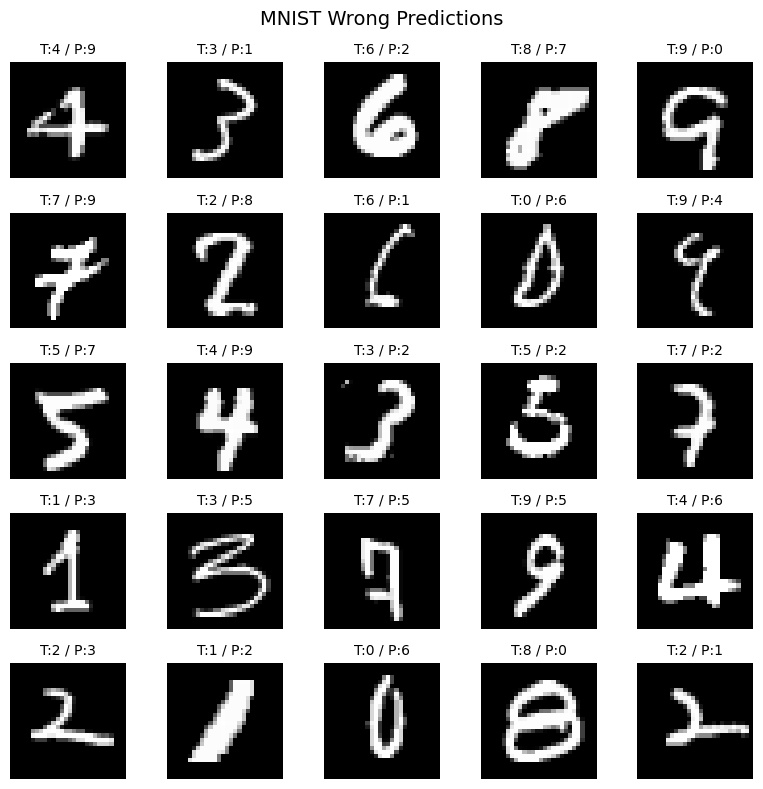

In [34]:
model.eval()
all_images, all_preds, all_labels = [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)

        all_images.append(X_batch.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_labels.append(y_batch.cpu().numpy())

# Stack all test data
X_all = np.concatenate(all_images)
y_all = np.concatenate(all_labels)
p_all = np.concatenate(all_preds)

# Find wrong predictions
wrong_idx = np.where(p_all != y_all)[0]

fig, axes = plt.subplots(5, 5, figsize=(8, 8))
fig.suptitle("MNIST Wrong Predictions", fontsize=14)

for ax, idx in zip(axes.flat, wrong_idx):
    img = X_all[idx][0]
    true_label = y_all[idx]
    pred_label = p_all[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"T:{true_label} / P:{pred_label}", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Further Improvements

1.  Could you change the attention mechanism to only receive attention
    from adjacent patches? -> attention_mask dans le transformer